# Task 1

In [105]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(42)
from sklearn.preprocessing import StandardScaler 
import seaborn as sns 
import cv2
import os 
from scipy.stats import stats
from PIL import Image
import matplotlib.image as mpimg

In [106]:
class PCA:

    def __init__(self, dir, img_name):#, n_components):
        
        #self.n = n_components
        self.name = img_name
        self.dir = dir
        self.img = cv2.cvtColor(cv2.imread(os.path.join(dir, img)), cv2.COLOR_BGR2RGB) 
        #self.img = cv2.imread(os.path.join(dir, img))

        # Split the image to three channels 
        self.blue, self.green, self.red = cv2.split(self.img)
        self.colors = np.array([self.red, self.green, self.blue])
        self.N_COMPONENTS = [1, 10, 20, 50, 100, 200, 300, 500, 768]
  
    def standardize(self):
        # Standardize the image (x-mu)/sigma 
        standard = []
        mu_all = []
        stds = []
        for color in self.colors:
            mu = np.mean(color, axis=0)
            std = np.std(color, axis=0)
            x = (color - mu)/ std 
            standard.append(x)
            mu_all.append(mu)
            stds.append(std)
        self.std = stds
        self.mu = mu_all
        return standard 
        
    def compute_covariance(self):
         
        z = self.standardize()
        #z = self.channels
        cov_mat = []
        for i in range(len(z)):
            cov_mat.append(np.cov(z[i], rowvar=False))
            #cov_mat.append(np.cov(z[i], rowvar=False))
        
        return cov_mat 
     
    def fit(self, n_components):

        #if self.n is None:
        #    pass 
        #else:
        self.n = n_components
        
        reconstructions = [[], [], []]
        acc_var = []
        scale = self.standardize()
        cov_mat = self.compute_covariance()

        for i, color in enumerate(self.colors):
            
            eigen_val, eigen_vects = np.linalg.eigh(cov_mat[i])
            
            # Sorting values and vectors in descending order
            new_vals = np.flip(eigen_val)
            new_vects = eigen_vects[:, np.argsort(new_vals)]
            n_comp = new_vects[:,0:self.n]
            new_color = np.dot(scale[i], n_comp)
            project_color = np.dot(new_color,n_comp.T)*self.std[i] + self.mu[i]
            reconstructions[i].append(project_color)
            acc_var.append(sum(new_vals[0:self.n])/sum(new_vals))

        compressed_img = (np.dstack((reconstructions[2][0], reconstructions[1][0], reconstructions[0][0]))).astype(np.uint8)

        return compressed_img, acc_var
            
    # Reconstruct the image with self.N_COMPONENTS components
    def reconstruct(self):
        
        img_list = []
        fig = plt.figure(figsize=(15, 10))
        for i in range(len(self.N_COMPONENTS)):
            compressed_img, _ = self.fit(n_components = self.N_COMPONENTS[i])
            fig.add_subplot(3, 3, i+1)
            plt.imshow(compressed_img)
            plt.title(f'{self.N_COMPONENTS[i]} Principle Components')

    # Plot accumulative variance by every channel
    def plot_variance_by_channels(self):

        var_b = []
        var_g = []
        var_r = []
        var_acc = []
        for i in range(len(self.N_COMPONENTS)):
            
            _, var = self.fit(n_components=self.N_COMPONENTS[i])
            var_b.append(var[0])
            var_g.append(var[1])
            var_r.append(var[2])
            #var_acc.append(sum(var))
        plt.plot(self.N_COMPONENTS, var_b, color='blue')
        plt.plot(self.N_COMPONENTS, var_g, color='green')
        plt.plot(self.N_COMPONENTS, var_r, color='red')
        #plt.plot(self.N_COMPONENTS, var_acc, color='yellow')
        plt.xlabel('Number of Components')
        plt.ylabel('Accumulative Variance')
        plt.legend(('Blue Channel Variance', 'Green channel Variance', 'Red channel Variance')) #, 'Cumulative Variance of channels'))

 

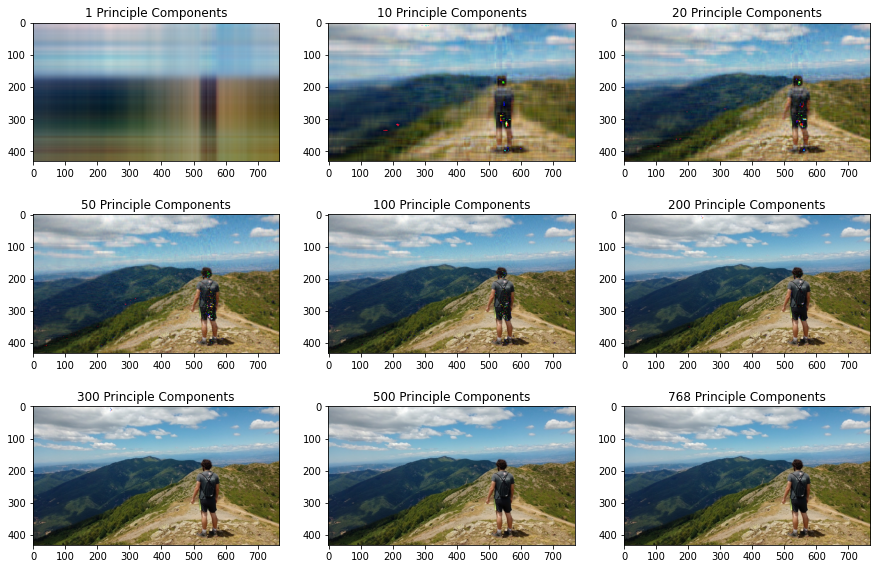

In [107]:
dir = '/content'
img = 'hw3_1.jpeg'  
pca = PCA(dir=dir, img_name=img)#, n_components=None)
#pca.actual_image()
pca.reconstruct()

### Accumulative Variance vs Number of Components

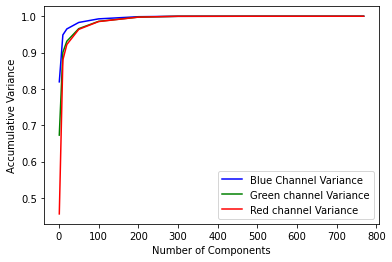

In [108]:
pca.plot_variance_by_channels()

# References ####
1) https://medium.com/@srv96/principal-component-analysis-from-scratch-932ff97eb27f

2) https://bagheri365.github.io/blog/Principal-Component-Analysis-from-Scratch/

3) https://www.askpython.com/python/examples/principal-component-analysis

# Task 2

#### Here we are going to implement multinomial naive bayes model as the chosen probabilistic model after studying the dataset as it is more suitable to the text classification model and multiple labels.

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score

## Read text file

#### Read US Name

In [14]:
# File is read using pandas read_csv file where header is not taken into consideration
english = pd.read_csv('us.txt', header=None)
# Column name is set to be Name
english.columns = ["Name"]
# A new column is set name nationality to store the name of country where name is used
english['Nationality'] = 'American'
english.head()

,Name,Nationality
0,Timothy Moses,American
1,Anna Barajas,American
2,James Caldwell,American
3,Mr. Michael Cole,American
4,Jeffrey Collier,American


#### Read Arabic Names

In [15]:
# File is read using pandas read_csv file where header is not taken into consideration
arabic = pd.read_csv('arabic.txt', header=None)
# Column name is set to be Name
arabic.columns = ["Name"]
# A new column is set name nationality to store the name of country where name is used
arabic['Nationality'] = 'Arabic'
arabic.head()

,Name,Nationality
0,رواء الموركة,Arabic
1,نشوة الشامي,Arabic
2,الدكتورة يسرى أفغاني,Arabic
3,سنام الزرقان,Arabic
4,المهندسة ليان القواسم,Arabic


#### Read Greek Names

In [16]:
# File is read using pandas read_csv file where header is not taken into consideration
greek = pd.read_csv('greek.txt', header=None)
# Column name is set to be Name
greek.columns = ["Name"]
# A new column is set name nationality to store the name of country where name is used
greek['Nationality'] = 'Greek'
greek.head()

,Name,Nationality
0,Αρίσταρχος Καρανίκας,Greek
1,Βέρα Δώρη,Greek
2,Ρέα-Ναυσικά Λαλαούνη,Greek
3,Ιοκάστη-Ηράκλεια Γαλανάκη,Greek
4,Λήδα-Μελπομένη Φωτιάδου,Greek


#### Read Japanese Names

In [17]:
# File is read using pandas read_csv file where header is not taken into consideration
japanese = pd.read_csv('japan.txt', header=None)
# Column name is set to be Name
japanese.columns = ["Name"]
# A new column is set name nationality to store the name of country where name is used
japanese['Nationality'] = 'Japanese'
japanese.head()

,Name,Nationality
0,鈴木 直子,Japanese
1,中川 陽一,Japanese
2,田中 香織,Japanese
3,林 零,Japanese
4,小林 千代,Japanese


## Combining all four name dataframe into one dataframe

In [18]:
# concat is done using pandas inbuilt function concat which concat all the dataframe 
# object into one where index from each dataframe is ignore to include in the 
# concated df
df = pd.concat([english, arabic, greek, japanese], axis=0, ignore_index=True)
print(df.shape)
df.head()

(4000, 2)


,Name,Nationality
0,Timothy Moses,American
1,Anna Barajas,American
2,James Caldwell,American
3,Mr. Michael Cole,American
4,Jeffrey Collier,American


## Vectorizer

#### A count vectorizer with ordinal encoding is used with fit and transform for transforming text into vector

In [19]:
# library
from sklearn.feature_extraction.text import CountVectorizer

# Calling object
count_vectorizer_object = CountVectorizer()
# training
count_vectorizer_object.fit(df['Name'])

# transform into vector
vectorized_matrix = count_vectorizer_object.transform(df['Name']).toarray()
vectorized_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### Ordinal encoder to encode ordinal data/target values

In [20]:
# defining a mapper to map the target or Nationality using ordinal encoder
mapper = [{'col': 'Nationality', 'mapping': {'American': int(0), 'Arabic': int(1), 'Greek': int(2), 'Japanese': int(3)}}]

# using user defined mapper
mapper_fun = OrdinalEncoder(mapping = mapper) 

# tranform the target variable
df = mapper_fun.fit_transform(df)

# example of dataframe
df

,Name,Nationality
0,Timothy Moses,0
1,Anna Barajas,0
2,James Caldwell,0
3,Mr. Michael Cole,0
4,Jeffrey Collier,0
...,...,...
3995,山下 稔,3
3996,木村 加奈,3
3997,三浦 翼,3
3998,石井 亮介,3


## Train test split with 70% training data size

In [21]:
train_x, test_x, train_y, test_y = train_test_split(vectorized_matrix, df['Nationality'], test_size = 0.3, shuffle=True)

## Multinomial Naive Bayes Class

In [22]:
# Here we are defining a Multinomial Naive Bayes Class which fit the dataset and train the model and later used that
# training for prediction.
import numpy
class multinomial_naive_bayes_model:
    def int(self, smooth_para = 10):
        # here smooth_parameter represents the technique to overcome the issue of zero number of variables present in
        # the features, here is smoothing parameter is increase the likelihood probability moves towards uniform
        # distribution, but as mentioned in the lecture we are preferring smoothing parameter = 1 as a base case.
        # Referred: Class Notes
        self.smooth_para = smooth_para

    def train(self, features, target):
        # get features samples and features
        self.features_samples, self.features_num = features.shape

        # assigning target to class variable
        self.target = target

        # get features
        self.features = features
        
        # get unique classes
        self.target_classes = numpy.unique(target)

        # get number of target class length
        self.class_len = self.target_classes.shape[0]

        # calculating prior probability by calculating each unique class in target
        # get prior probability
        self.prior_prob = numpy.zeros((self.class_len))
        temp, self.uni_tar = numpy.unique(self.target, return_counts=True)
        for idx in range(self.target_classes.shape[0]):
            self.prior_prob[idx] = self.uni_tar[idx]/self.features_samples
        
        # initialize two variables with number of zeroes
        self.t1 = numpy.zeros((self.class_len))
        self.t2 = numpy.zeros((self.class_len, self.features_num))

        # iterate over classes target:
        for class_idx in self.target_classes:
            temp2 = numpy.argwhere(self.target.to_numpy()==class_idx).flatten()
            add_col = []
            for idx2 in range(self.features_num):
                add_col.append(numpy.sum(self.features[temp2,idx2]))

            # initializing with 1d array and 2d array
            self.t1[class_idx] = numpy.sum(add_col)
            self.t2[class_idx] = add_col

    # finding prob of a given b
    def prob_ab(self, feat, idx, idx2):
        count_target_idx = self.t2[idx2, idx]
        count_target = self.t1[idx2]

        cal = (count_target_idx+self.smooth_para)/(count_target+ (self.smooth_para*self.features_num))
        cal = numpy.power(cal, feat)
        return cal

    def predict(self, test_feature, smooth_para = 10):
        self.smooth_para = smooth_para
        # get sample and features
        self.test_samples, self.test_features = test_feature.shape

        # get predicted probability
        self.predicted_probability = numpy.zeros((self.test_samples, self.class_len))

        # iterate over for loop
        test_f0 = test_feature.shape[0]
        for idx in range(test_f0):
            jp = numpy.zeros((self.class_len))

            # get likelihood
            for idx2 in range(self.class_len):
                # likelihood
                lst = []
                # print(self.test_feature)
                for j in range(test_feature[idx].shape[0]):
                    lst.append(self.prob_ab(test_feature[idx][j], j, idx2))

                likelihood = numpy.prod(lst)

                # joint likelihood which gives prob of a given b * prob(target)
                jp[idx2] = likelihood * self.prior_prob[idx2]

            # naive bayes numerator and denominator
            # get denominator
            cal1 = numpy.sum(jp)

            # get numerator and return sum
            for idx3 in range(self.class_len):
                cal0 = jp[idx3]
                self.predicted_probability[idx, idx3] = (cal0/cal1)


        # return max value result
        idx_max = numpy.argmax(self.predicted_probability, axis=1)
        print(idx_max)
        return self.target_classes[idx_max]

## Train Test model

In [23]:
# call class
multinomial_nb_model = multinomial_naive_bayes_model()

# train model with training dataset
multinomial_nb_model.train(train_x, train_y)

# predict after training 
prediction = multinomial_nb_model.predict(test_x)

# get accuracy
print('Accuracy: %.4f '% accuracy_score(prediction, test_y))

[3 3 0 ... 0 3 0]
Accuracy: 0.9458 


For smooth parameter selected I received more accuracy while selecting smooth parameter = 10. Compare it with smooth parameter 1, 5 and 10.

###### References

1. https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece

2. https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/

3. https://www.kaggle.com/code/riyadhrazzaq/multinomial-naive-bayes-from-scratch/notebook

4. https://towardsdatascience.com/name-classification-with-naive-bayes-7c5e1415788a